In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cho_factor,cho_solve
#from scipy.spatial.distance import cdist

#import some useful functions from local files
from mini_inferno import miniMCMC, fopt, miniSamplePlot, apply_uniform_prior
from mini_PlanetFuncs import transit


***

## Introduction

This tutorial is going to demonstrate how to write a simple but practical Gaussian process (GP) model that can be used to model datasets in a non-parametric way, focussing on their application to fitting transit light curves, but this can be easily generalised to other datasets.

The idea is to develop an understanding of GPs beyond using exisiting codes as black boxes, and also to demonstrate that writing your own GP code is really quite simple!

First we are going to look at some generic model fitting using $\chi^2$ and Gaussian i.i.d. likelihood functions. The definitions are as follows:

$
\begin{align}
\chi^2 = \sum_{i=1}^N \frac{(f_i - m(\theta,x_i))^2}{\sigma_i^2}
\end{align}
$

$
\begin{align}
\mathcal{L(\theta)} = \prod_{i=1}^N\frac{1}{\sqrt{2\pi\sigma_i^2}}\exp\left(-\frac{1}{2} \frac{(f_i - m(\theta,x_i)^2}{\sigma_i^2}\right) = \left[\prod_{i=1}^N\frac{1}{\sqrt{2\pi\sigma_i^2}}\right]\exp\left(-\frac{1}{2} \chi^2\right)
\end{align}
$

In practice we use the log likelhood:

$
\begin{align}
\log\mathcal{L(\theta)} = -\frac{1}{2} \chi^2 - \sum_{i=1}^N\log(\sigma_i) - \frac{N}{2}\log(2\pi)
\end{align}
$

(we can safely ignore the final constant term as it cancels out in likelhood ratios or is irrelevant for optimisation)


In [2]:
# Let's first define these functions in python
#
# theta - array of model parameters
# model - model function we are fitting (m above) called as model(theta,*func_args)
# x - array of inputs to the function, eg time for a light curve
# y - array of datapoints measured at x, eg flux for a light curve
# sig - array of uncertainties sigma

def chi2(theta,model,x,y,sig):
  return np.sum(((y - model(theta,x)) / sig)**2)

def logL(theta,model,x,y,sig):
  return -0.5*chi2(theta,model,x,y,sig) - np.log(sig).sum()


We might also want to use a prior to account for our currnet knowledge of the parameters and create a (log) posterior, either for full Bayasian inference or for constraining optimisers. The posterior distribution is just the likelihood of the data given a set of model parameters $\mathcal{L}(\mathcal{D}|\theta)$ times the prior distribution of the parameters $\pi(\theta)$ which represents our knowledge of the parameters before oberving the data $\mathcal{D}$. There is also a normalisation term (the evidence) which is used for model selection but not required for parameter estimation. Therefore our posterior distribution is:

$
\begin{align}
\mathcal{P}(\theta|\mathcal{D}) \propto \mathcal{L}(\mathcal{D}|\theta) \, \pi(\theta)
\end{align}
$

and log posterior:

$
\begin{align}
\log\mathcal{P}(\theta|\mathcal{D}) = \log\mathcal{L}(\mathcal{D}|\theta) + \log\pi(\theta) + C
\end{align}
$

where we can ignore the constant C.

Here we will only consider uniform priors, where the prior equals 1 within some bounds, and 0 elsewhere (or $\log\mathcal{L}$ is 0 or -$\infty$, respectively). The simple function below takes in a logL function and a series of bounds, and spits out a posterior distribution which returns -np.inf if outside the prior bounds.

*Improper priors are fine for inferring parameters from a model (for the same reason that we don't need to normalise the posterior), but not for model selection which (nearly) always is subjective!*


In [3]:
#We can simply define the logPosterior explicitly, just calling the logL within the function
def logP_example1(p,*args):
  """
  example of a posterior with uniform prior on p[0] and p[1]
  """
  if p[0] < 0 or p[0] > 1: return -np.inf
  if p[1] < 0 or p[1] > 1: return -np.inf

  return logL(p,*args)

#I'm going to use a convenience function (a function decorator) to do the same thing
# bounds - list of (lower/upper) bounds for each parameter
bounds = [(0,1),(-np.inf,np.inf),None,(-10,10),(2,9)]
logP_example2 = apply_uniform_prior(logL,bounds)


***

## Example of simple transit fit with white noise

Now let's define some simulated data to test our functions on. We are going to use a simple transit light curve model with *no limb darkening*. Obviously in practice we need to consider the wavelength dependence of limb darkening, but this will suffice to demonstrate GPs.


<IPython.core.display.Javascript object>


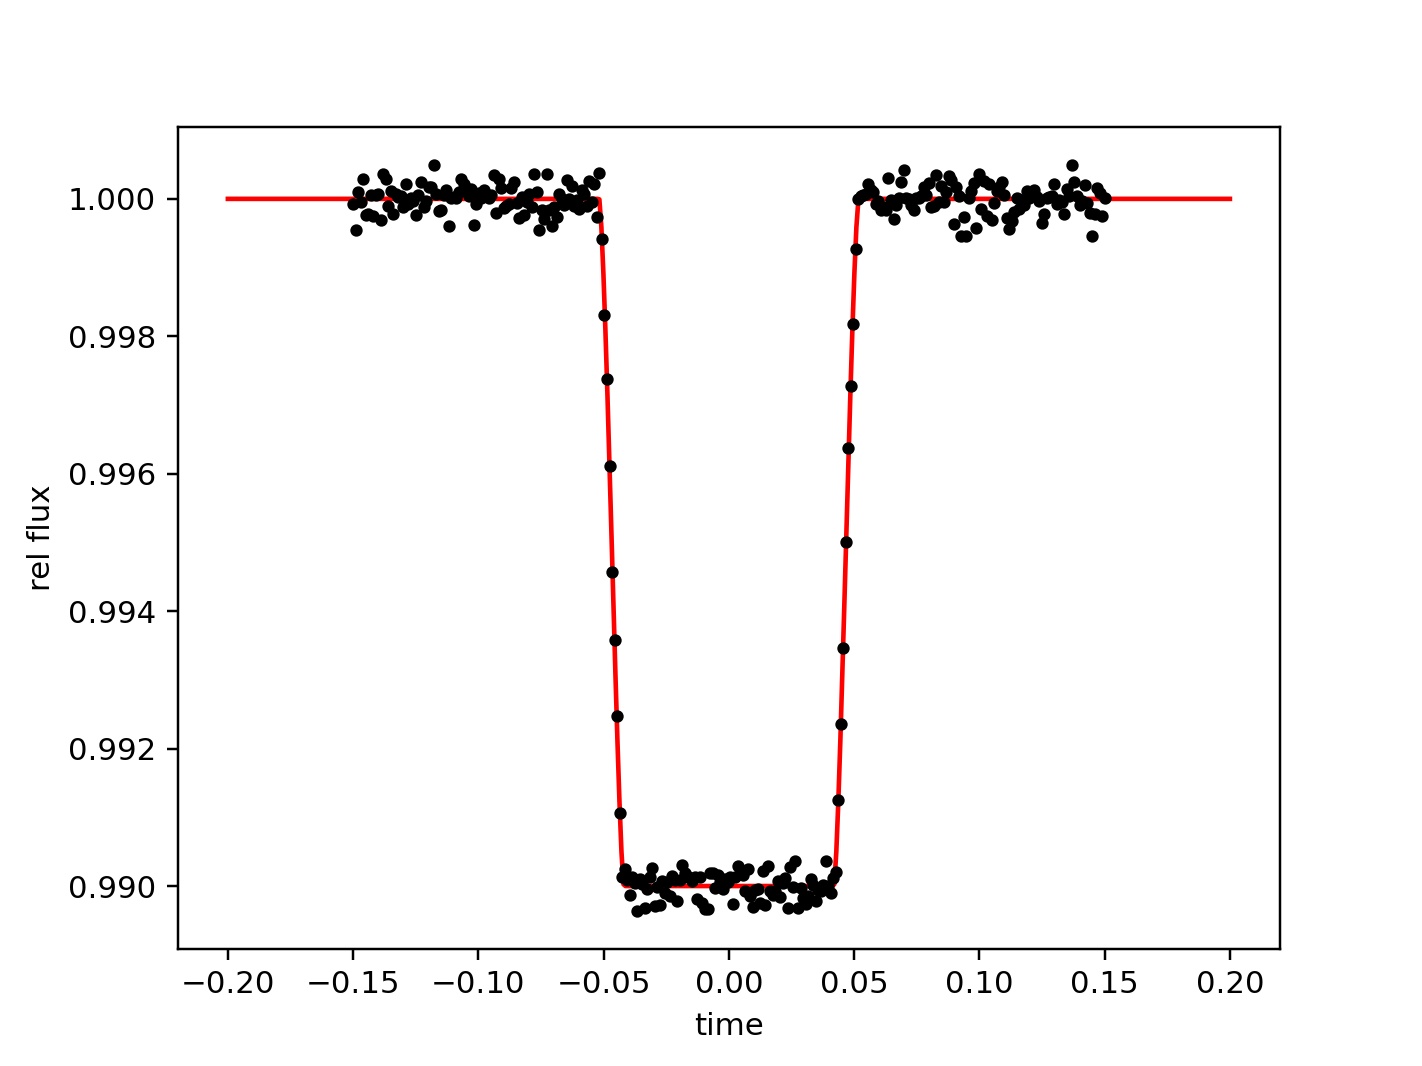

In [4]:
# The function is called first with parameter vector p (equivalent to theta in the equations), and with time t
# flux = transit(p,time)
# p = [T0,P,aRs,rho,b,foot,Tgrad]
# where:
# T0 - central transit time
# P - orbital period
# aRs - semi-major axis in units of stellar radius (system scale) or a/R_star
# rho - planet-to-star radius ratio - the parameter of interest for trasmission spectroscopy
# b - impact parameter
# foot - out-of-transit flux
# Tgrad - linear gradient of basis function

#create some labels for each parameter for plotting
transit_labels = [r'$T_0$',r'$P$',r'$a/R_\bigstar$',r'$R_\mathrm{p}/R_\star$',r'$b$',r'$f_\mathrm{oot}$',r'$T_\mathrm{grad}$']

#we will also set a series of lower and upper limits on the transit parameters for priors
transit_bounds = [None,None,(0,np.inf),(0,np.inf),(0,np.inf),(0,np.inf),None,]

#now let's generate some data
time = np.linspace(-0.15,0.15,300)
time_pred = np.linspace(-0.2,0.2,500)
par = np.array([0,3,10,0.1,0.2,1.,0])

#use the transit function to simulate some data at time t with noise
wn = 0.0002 # white noise
flux = transit(par,time) + np.random.normal(0,wn,time.size)

#we also need to create the uncertanties
sigma = np.ones(flux.size) * wn

a = plt.subplot(xlabel='time',ylabel='rel flux')
a.plot(time_pred, transit(par,time_pred),'r-')
a.plot(time,flux,'k.')


We are now (finally!) ready to infer the parameters of the light curve model.
We can do this in a number of ways.

- option 1: minimise the $\chi^2$
- option 2: maximise the log likelhood $\log\mathcal{L}$
- option 3: maximise the log posterior $\log\mathcal{P}$
- option 4: get samples from the posterior distribution using an MCMC

Note that another option is to use least-squares methods such as the Levenburg-Marquart algorithm, but this will not work for a GP, so we are ignoring it here.


<IPython.core.display.Javascript object>


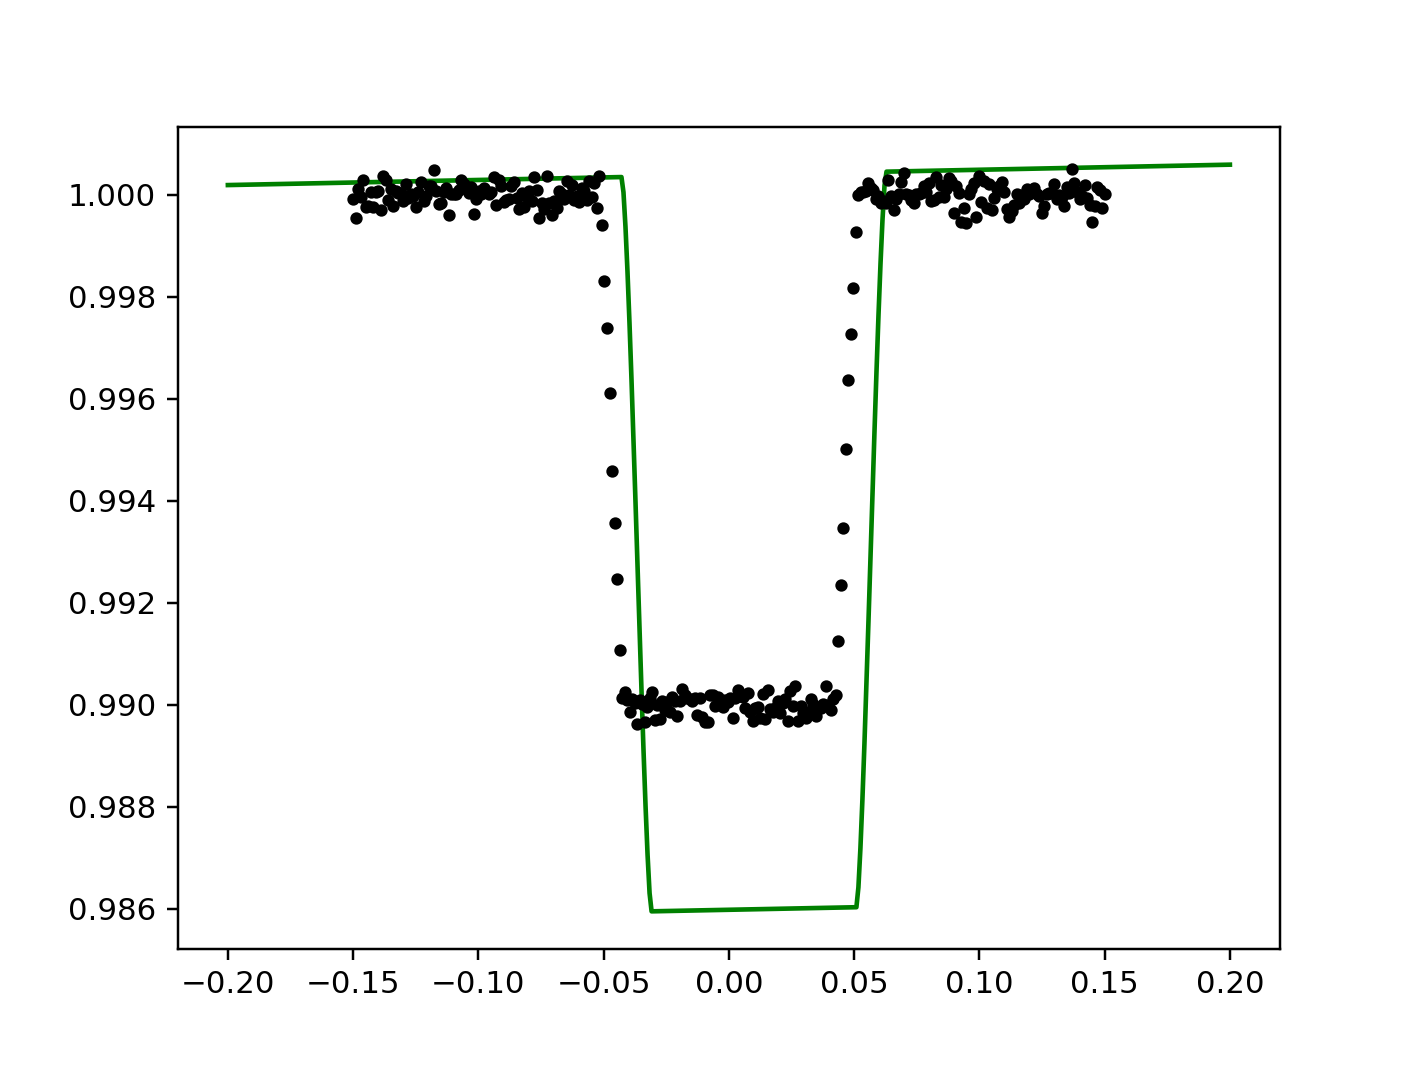

In [5]:
#let's start with an (incorrect) estimate of the parameters and uncertainties
#define array of guess parameters and uncertainties
# par = np.array([0,3,10,0.1,0.2,1.,0])
p = np.array([0.01,3,10,0.12,0.2,1.0004,0.001])
e = np.array([0.0001,0,0,0.0001,0,0.00002,0.00002])

#plot the initial guess of the transit
f,a = plt.subplots()
a.plot(time_pred, transit(p,time_pred),'g-')
a.plot(time,flux,'k.')

In [6]:
#we can now easily compute the chi2 or logL/P for our model given a set of parameters
print("chi2 = {:.5}".format( chi2(p,transit,time,flux,sigma) ))
print("logL = {:.5}".format( logL(p,transit,time,flux,sigma) ))
logP = apply_uniform_prior(logL,transit_bounds) #apply prior to logL
print("logP = {:.5}".format( logP(p,transit,time,flux,sigma) ))

chi2 = 8.5379e+04
logL = -4.0134e+04
logP = -4.0134e+04


Optimization terminated successfully.
         Current function value: 288.574275
         Iterations: 237
         Function evaluations: 393
reduced chi2 = 0.97
Optimization terminated successfully.
         Current function value: -2410.870820
         Iterations: 236
         Function evaluations: 392
Optimization terminated successfully.
         Current function value: -2410.870820
         Iterations: 236
         Function evaluations: 392


<IPython.core.display.Javascript object>


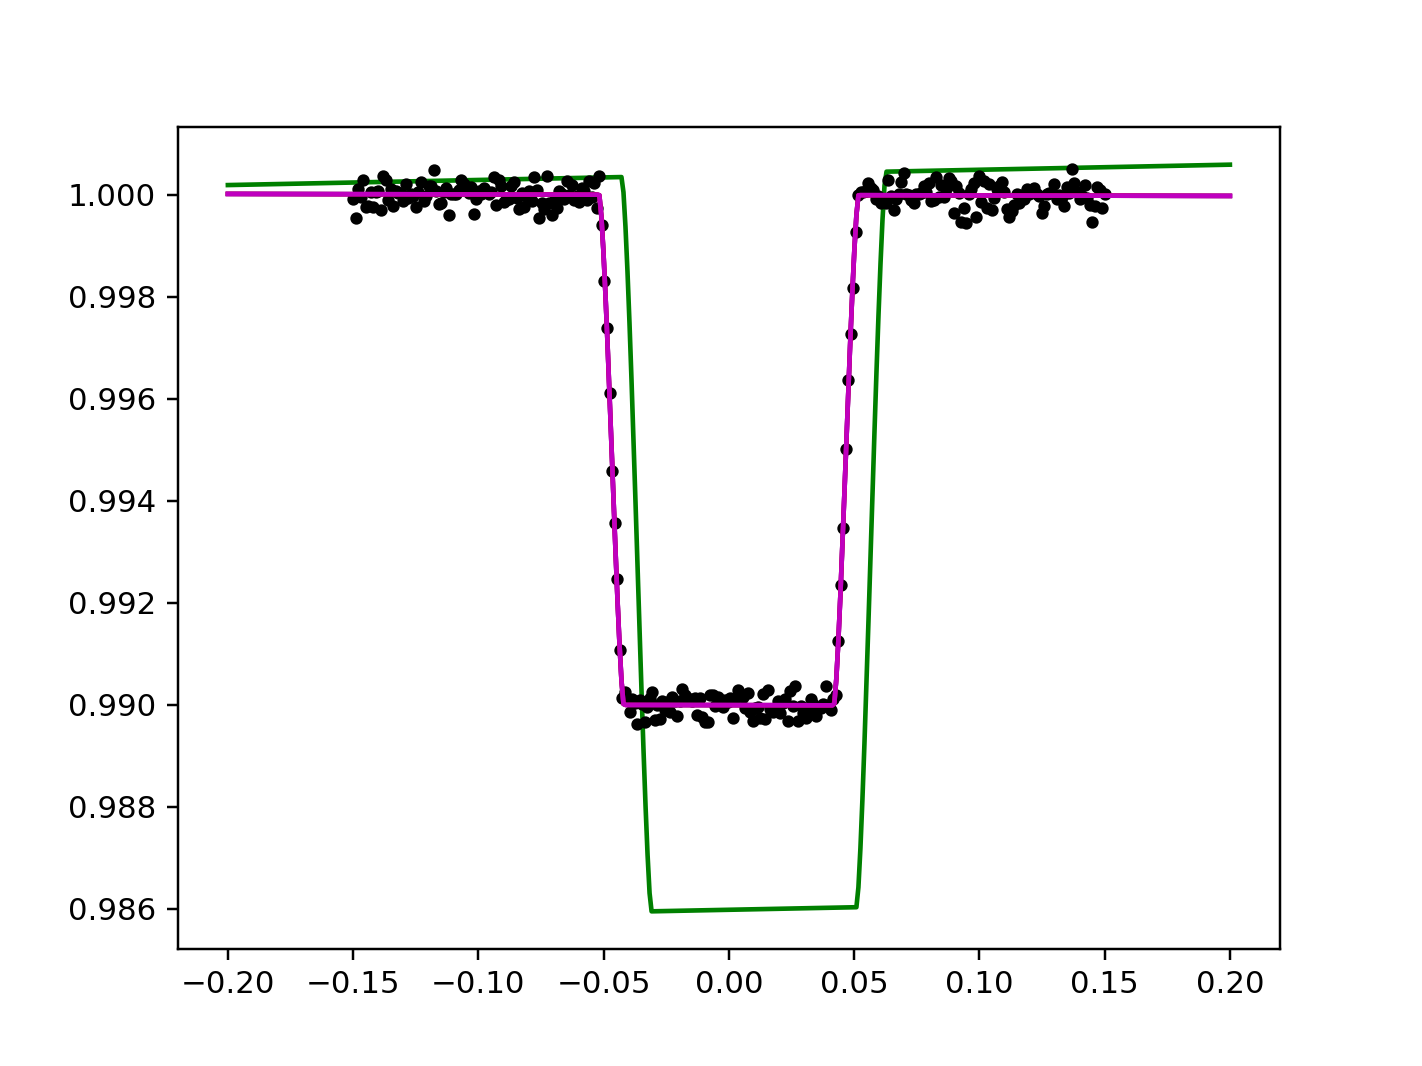

In [7]:
#option 1: minimise chi2
p_fit_chi2 = fopt(chi2,p,var=e>0,args=(transit,time,flux,sigma),min=True)
print('reduced chi2 = {:.2f}'.format(chi2(p_fit_chi2,transit,time,flux,sigma)/(flux.size-np.sum(e>0))))

#option 2: maximise the log likelihood
p_fit_logL = fopt(logL,p,var=e>0,args=(transit,time,flux,sigma))

#option 3: maximise the log posterior - first create list of bounds and create posterior
p_fit_logP = fopt(logP,p,var=e>0,args=(transit,time,flux,sigma))

#now make a plot of the best fit models
f,a = plt.subplots()
a.plot(time_pred, transit(p,time_pred),'g-')
a.plot(time,flux,'k.')
a.plot(time_pred, transit(p_fit_chi2,time_pred),'b-')
a.plot(time_pred, transit(p_fit_logL,time_pred),'r-')
a.plot(time_pred, transit(p_fit_logP,time_pred),'m-')

running mcmc chain:   0%|          | 0/1000 [00:00<?, ?it/s]

Total time: 0m 3.19s
Final acceptance = 35.5875%


<IPython.core.display.Javascript object>


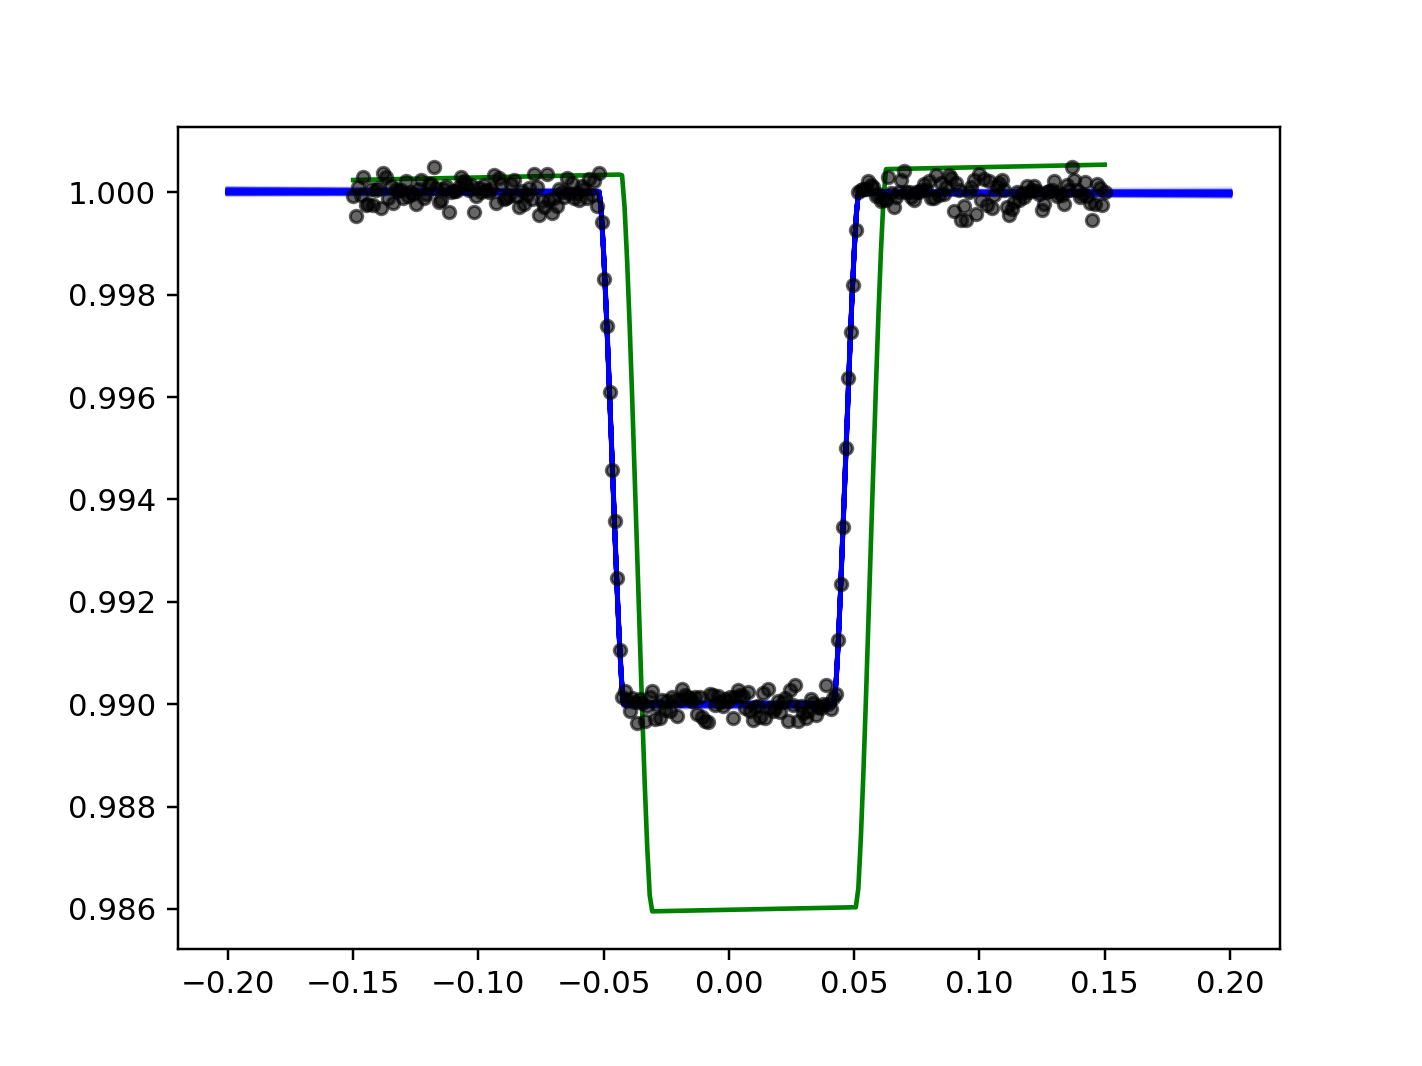

<IPython.core.display.Javascript object>


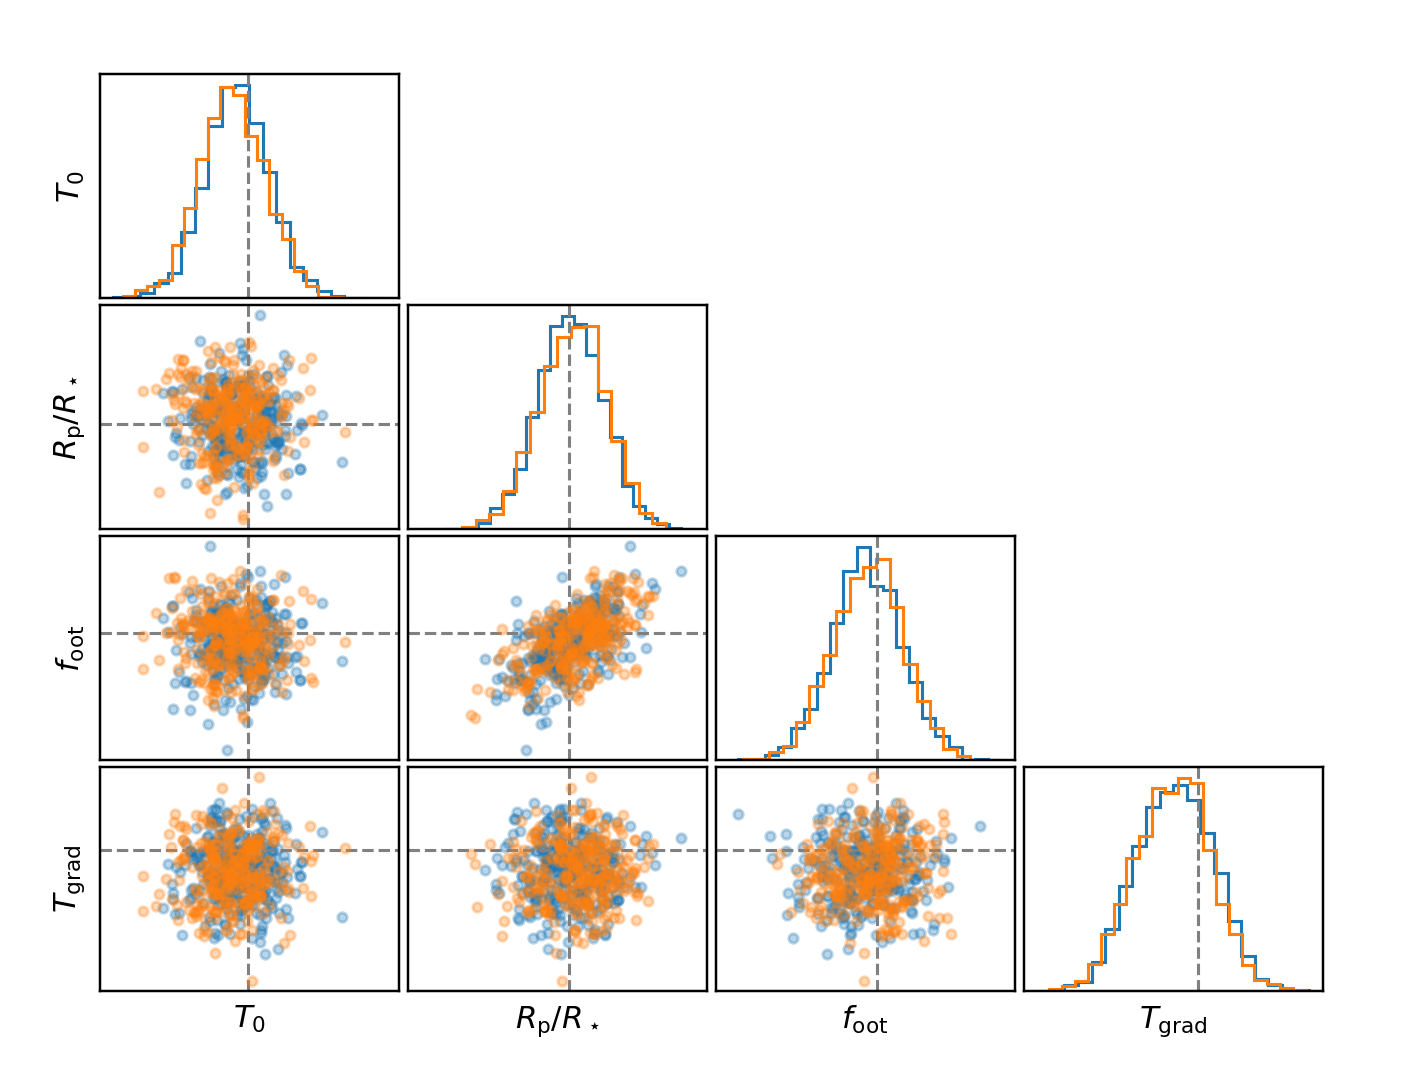

p[0] = -0.00002 +- 0.00004
p[1] = 3.00000 +- 0.00000
p[2] = 10.00000 +- 0.00000
p[3] = 0.10001 +- 0.00013
p[4] = 0.20000 +- 0.00000
p[5] = 1.00000 +- 0.00001
p[6] = -0.00009 +- 0.00014


In [8]:
#option 4: use an MCMC to optimise and get the uncertainties
n_chains,burnin,chain=32,400,600
d = miniMCMC(logP,p_fit_logP,e/100,burnin,chain,N=n_chains,args=(transit,time,flux,sigma))
p_fit_MCMC,e_fit_MCMC = d['p'],d['e']

#now make a plot of the best fit models
f,a = plt.subplots()
a.plot(time, transit(p,time),'g-')
a.plot(time, transit(p_fit_MCMC,time),'r-')
#plot some samples from the MCMC
X = d['chains'][np.random.randint(0,chain,100),np.random.randint(0,n_chains,100)]
for x in X: a.plot(time_pred, transit(x,time_pred),'b-',alpha=0.1)
a.plot(time,flux,'ko',ms=4,alpha=0.6)

#and also plot the chains (need to add function)
miniSamplePlot(d['chains'],2,labels=transit_labels,x=par)

#print out the results
for i in range(len(p)):
  print("p[{}] = {:.5f} +- {:.5f}".format(i,p_fit_MCMC[i],e_fit_MCMC[i]))


***

## Our first GP!

The big advantage in using the likelihood instead of $\chi^2$, is that we can also fit for the noise/uncertainties.  This leads to our first Gaussian process! To implement this we can consider a scaling function for the uncertainties, $\beta$:

$
\begin{align}
\mathcal{L(\theta)} = \prod_{i=1}^N\frac{1}{\sqrt{2\pi(\color{red}{\beta}\sigma_i)^2}}\exp\left(-\frac{1}{2} \frac{(f_i - m_i(\theta))^2}{(\color{red}{\beta}\sigma_i)^2}\right)
\end{align}
$

or simply use the same uncertainty for all inputs, $\sigma_{\mathrm{w}}$ (where the 'w' stands for white noise), which we will do here:

$
\begin{align}
\mathcal{L(\theta)} = \prod_{i=1}^N\frac{1}{\sqrt{2\pi\color{red}{\sigma_{\mathrm{w}}}^2}}\exp\left(-\frac{1}{2} \frac{(f_i - m_i(\theta))^2}{\color{red}{\sigma_{\mathrm{w}}}^2}\right)
\end{align}
$

leading to the log likelhood:

$
\begin{align}
\log\mathcal{L(\theta)} = -\frac{1}{2} \sum_{i=1}^N \frac{(f_i - m(\theta,x_i))^2}{\color{red}{\sigma_{\mathrm{w}}}^2} - N\log(\color{red}{\sigma_{\mathrm{w}}})
\end{align}
$

Note that for the $\chi^2$ function, the uncertainty term only appears once! 

$
\begin{align}
\chi^2 = \sum_{i=1}^N \frac{(f_i - m(\theta,x_i))^2}{\sigma_\mathrm{w}^2}
\end{align}
$


In the likelihood, it appears twice. When optimising the likelihood, one term wants to go to infinity, and the other wants to go to zero. It is finding the balance between these two extremes that allows us to infer the noise properties.

This is now a Gaussian process, because it is defined for any input $x_i$.


In [9]:
# def logL(theta,model,x,y,sig):
#   return -0.5*chi2(theta,model,x,y,sig) - np.log(sig).sum()

def logL_wn(p,func,x,y):
  chi2_wn = np.sum(((y - func(p[:-1],x)) / p[-1])**2)
  return -0.5*chi2_wn - y.size * np.log(p[-1])

#as before create a log posterior function to limit parameter space
logP_wn = apply_uniform_prior(logL_wn,transit_bounds+[(0,np.inf)])

#create new parameter arrays for starting point of optimisation
p = np.array([0.01,3,10,0.12,0.2,1.001,0.0003] + [wn,])
e = np.array([0.0001,0,0,0.0001,0,0.00002,0.00002] + [0.001])


Now we can fit the light curve in the same way as before, but now also *inferring the noise*!

Optimization terminated successfully.
         Current function value: -2410.982438
         Iterations: 339
         Function evaluations: 547


running mcmc chain:   0%|          | 0/1000 [00:00<?, ?it/s]

Total time: 0m 2.71s
Final acceptance = 33.21875%


<IPython.core.display.Javascript object>


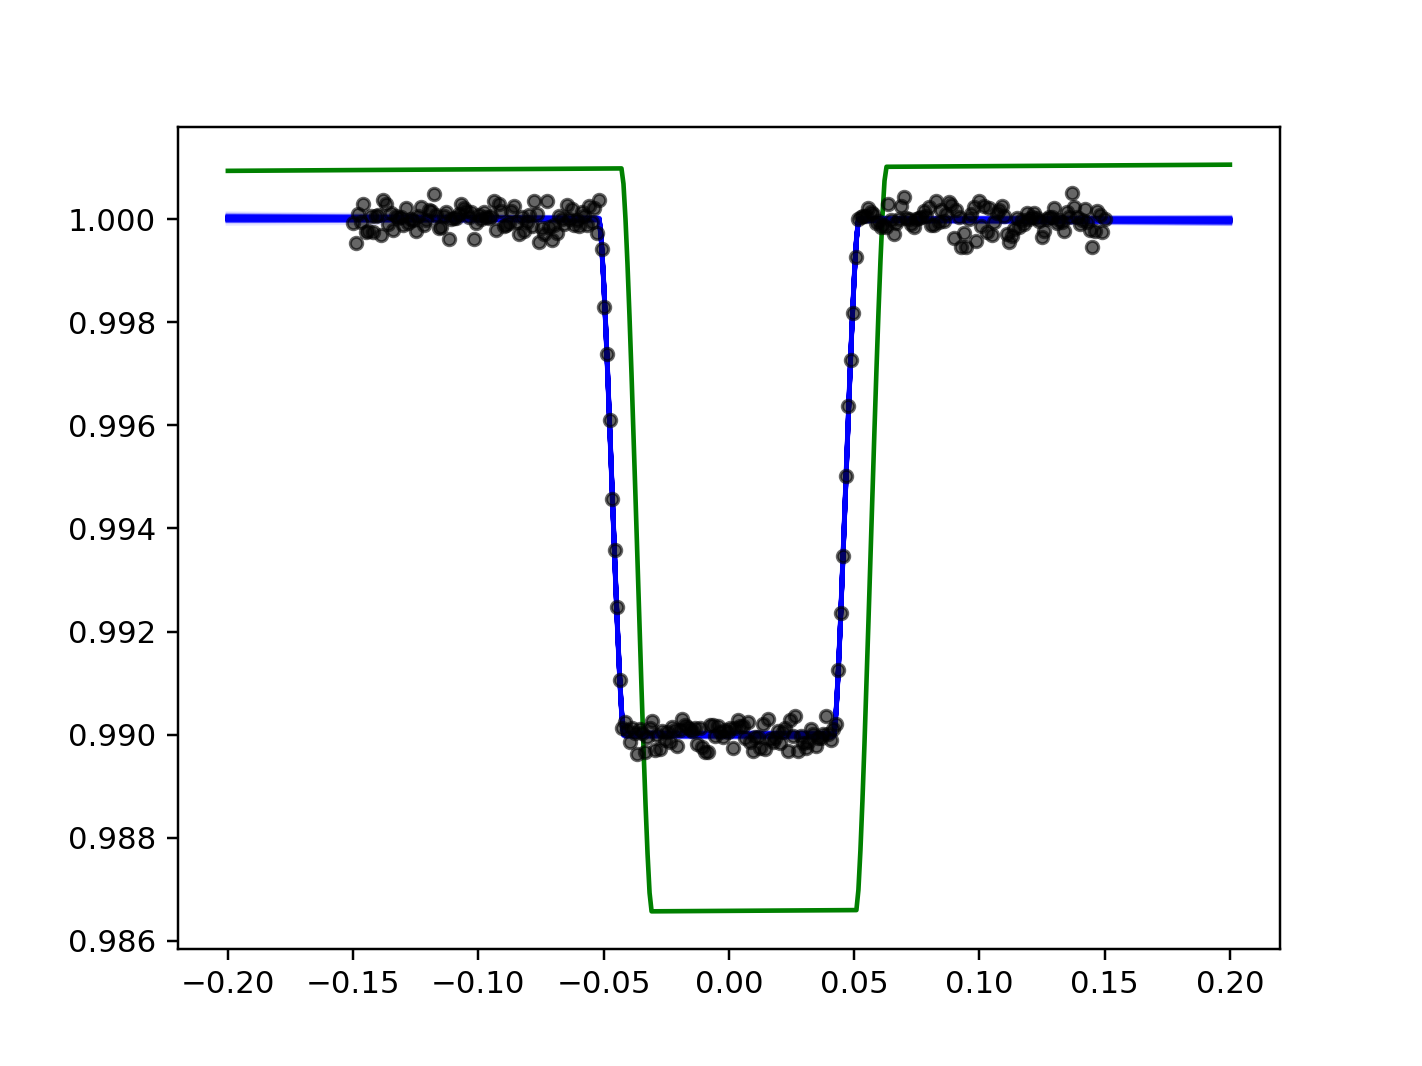

<IPython.core.display.Javascript object>


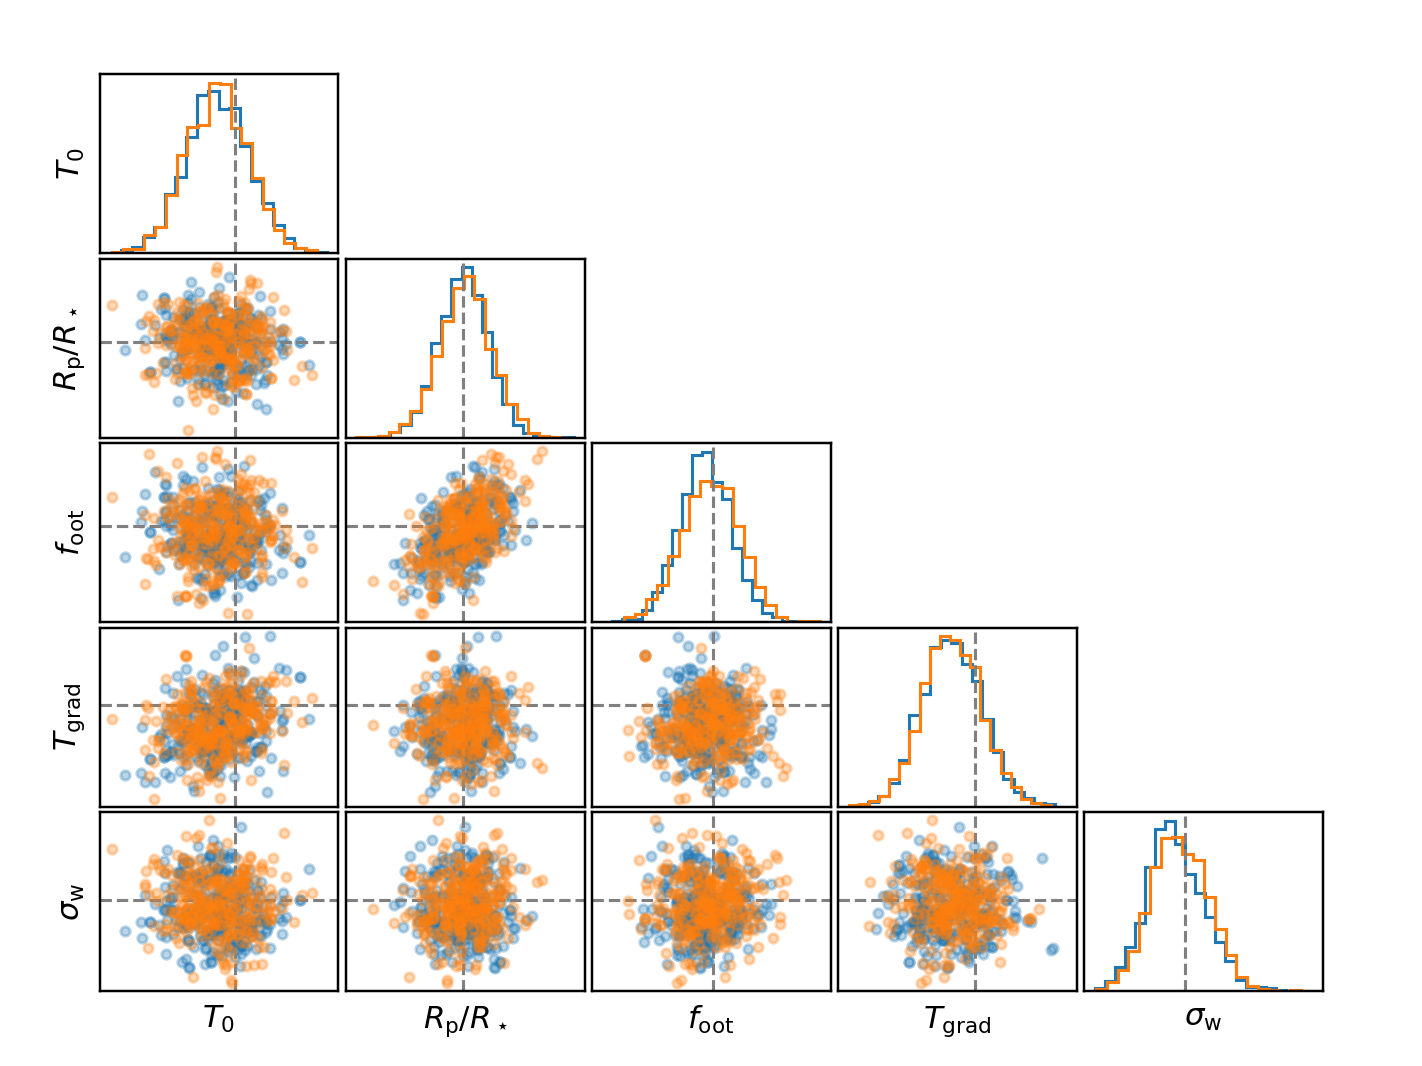

p[0] = -0.00002 +- 0.00004
p[1] = 3.00000 +- 0.00000
p[2] = 10.00000 +- 0.00000
p[3] = 0.10000 +- 0.00012
p[4] = 0.20000 +- 0.00000
p[5] = 1.00000 +- 0.00001
p[6] = -0.00010 +- 0.00013
p[7] = 0.00020 +- 0.00001


In [10]:
#fit with simple optimiser
p_fit = fopt(logP_wn,p,var=e>0,args=(transit,time,flux),min=False)
#p_fit = fopt(logP_wn,p_fit,var=e>0,args=(transit,time,flux),min=False) #sometimes need to run this twice

#run an MCMC
d = miniMCMC(logP_wn,p_fit,e/100,burnin,chain,N=n_chains,args=(transit,time,flux))
p_fit_MCMC,e_fit_MCMC = d['p'],d['e'] #get mean and uncertainties

#now make a plot of the best fit models
f,a = plt.subplots()
a.plot(time_pred, transit(p[:-1],time_pred),'g-')
a.plot(time_pred, transit(p_fit[:-1],time_pred),'r-')
a.plot(time_pred, transit(p_fit_MCMC[:-1],time_pred),'b-')
#plot some samples from the MCMC
X = d['chains'][np.random.randint(0,chain,100),np.random.randint(0,n_chains,100)]
for x in X: a.plot(time_pred, transit(x[:-1],time_pred),'b-',alpha=0.1)
a.plot(time,flux,'ko',ms=4,alpha=0.6)

#and also plot the chains (need to add function)
miniSamplePlot(d['chains'],2,labels=transit_labels+[r'$\sigma_\mathrm{w}$'],x=np.hstack([par,wn]))

#print out the results
for i in range(len(p)):
  print("p[{}] = {:.5f} +- {:.5f}".format(i,p_fit_MCMC[i],e_fit_MCMC[i]))


***

## A fully working GP

So far, we've only considered the i.i.d. normal likelihood:

$
\begin{align}
\mathcal{L(\theta)} = \prod_{i=1}^N\frac{1}{\sqrt{2\pi{\sigma_{\mathrm{w}}}^2}}\exp\left(-\frac{1}{2} \frac{(f_i - m_i(\theta))^2}{{\sigma_{\mathrm{w}}}^2}\right)
\end{align}
$

To produce a non-trivial GP, we now need to consider the more general case of a multivariate Gaussian distribution:

$
\begin{align}
\mathcal{L(\theta)} = \frac{1}{\sqrt{2\pi|\Sigma|}}\exp\left(-\frac{1}{2} r^T\Sigma^{-1}r  \right)
\end{align}
$

where r is the vector of residuals $r_i = f_i - m(\theta,x_i)$, and $\Sigma$ is the *covariance matrix*. For our previous example, $\Sigma$ was simply a diagonal matrix with values $\sigma_{w}$:

$
\begin{align}
\Sigma =
\begin{bmatrix}
\sigma_w^2 & 0 & \dots & 0 \\
0 & \sigma_w^2 & \dots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \dots & \sigma_w^2 \\
\end{bmatrix}
\end{align}
$

As before we'll first define our log likelhood function and remove constant terms:

$
\begin{align}
\log\mathcal{L(\theta)} = -\frac{1}{2} r^T\Sigma^{-1}r - \frac{1}{2}\log|\Sigma|
\end{align}
$



In [11]:
# from scipy.linalg import cho_factor,cho_solve

def logL_multivariate_normal(r,K):
  #use cholesky factorisation to solve for K^-1 x r and get log determinant of K
  choF = cho_factor(K,check_finite=False)
  half_logdetK = np.log(np.diag(choF[0])).sum()
  #compute the log Likelihood
  logL = -0.5 * np.dot(r,cho_solve(choF,r,check_finite=False)) - half_logdetK
  return logL


Currently we just have a multivariate Gaussian distribution. To make this a Gaussian process, we need a *kernel function*. This is just a simple function that populates the covariance matrix. For this tutorial, we will stick with the squared exponential kernel.

$
\begin{align}
\Sigma_{nm} = k_{SE}(x_n,x_m) = \theta^2 \exp \left( - \frac{\Delta x^2}{2l^2}\right) + \delta_{nm}\sigma_\mathrm{w}^2
\end{align}
$

where $l$ is a length scale, $\theta$ is the height scale, and $\sigma_\mathrm{w}$ is the white noise as before. $\Delta x$ is the different in the inputs $\Delta x = x_n - x_m$. This is simply a Gaussian-shaped kernel, where points nearby each other in $x$ have high covariance, and points far away from each other (in terms of $x$) have low covariance. The length scale govens the definition of 'closeness', and the height scale shows the size of the variations. This is best illustrated by an example. Let's first define the kernel function.

[[1.01   0.6065 0.1353 0.0111 0.0003]
 [0.6065 1.01   0.6065 0.1353 0.0111]
 [0.1353 0.6065 1.01   0.6065 0.1353]
 [0.0111 0.1353 0.6065 1.01   0.6065]
 [0.0003 0.0111 0.1353 0.6065 1.01  ]]
[[1.01   0.6065]
 [0.6065 1.01  ]
 [0.1353 0.6065]
 [0.0111 0.1353]
 [0.0003 0.0111]]


<IPython.core.display.Javascript object>


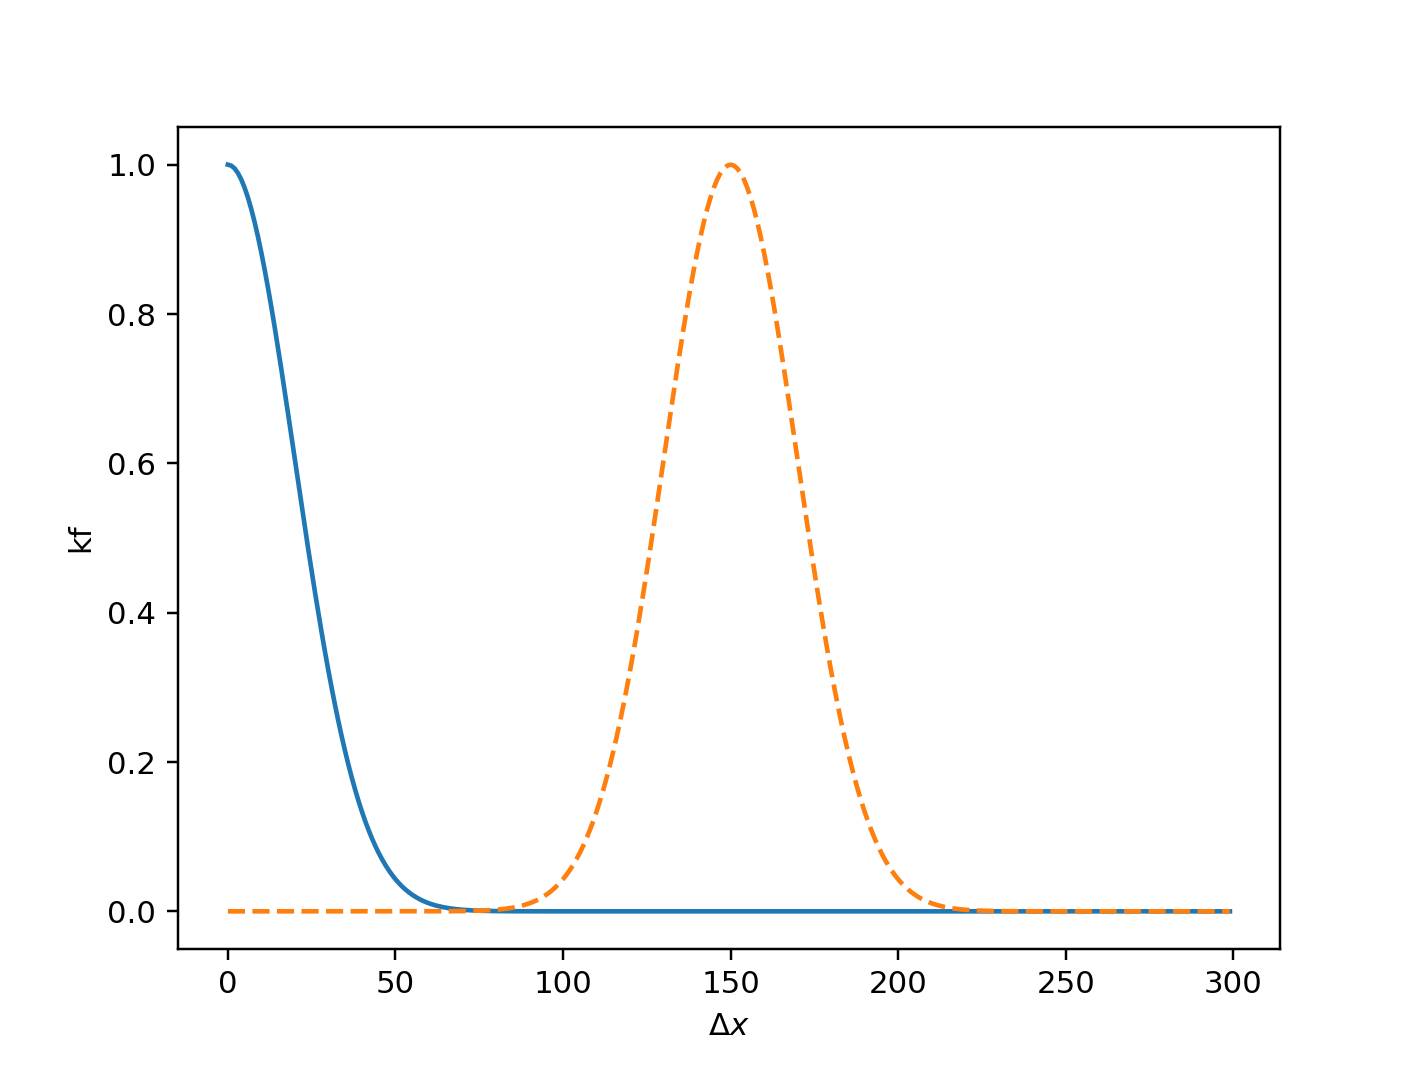

In [12]:
def kf(x,y,p,wn=True):
  """
  Squared exponential kernel function.
  
  x - first vector of inputs
  y - second vector of inputs
  p = [height scale, length scale, white noise]
  
  """
  D = np.subtract.outer(x/p[1],y/p[1]) # delta x/l array
  D2 = np.square(D) #delta x squared
  K = p[0]**2 * np.exp(-0.5*D2) #compute kernel
  if wn == True: np.fill_diagonal(K,p[0]**2+p[2]**2) #add white noise to the diagonal
  return K

#this returns a 2D array array, e.g.:
np.set_printoptions(precision=4,suppress=True)
K = kf(np.arange(5),np.arange(5),[1,1,0.1])
print(K)
K = kf(np.arange(5),np.arange(2),[1,1,0.1])
print(K)

#get a covariance matrix for our time array
K = kf(time,time,[1,0.02,0.])
plt.figure()
a = plt.subplot(xlabel=r'$\Delta x$',ylabel='kf')
a.plot(K[0])
a.plot(K[K.shape[0]//2],ls='--')


A normal distribution $\mathcal{N}(\mu,\Sigma)$ is fully defined by its mean $\mu$ and covariance matrix $\Sigma$, and we can easily take random draws from it. When we map a multivariate Gaussian distribution to a vector of inputs $x$, and the outputs to a vector $y$, we can now consider this a prior distribution over a *function space*.


<IPython.core.display.Javascript object>


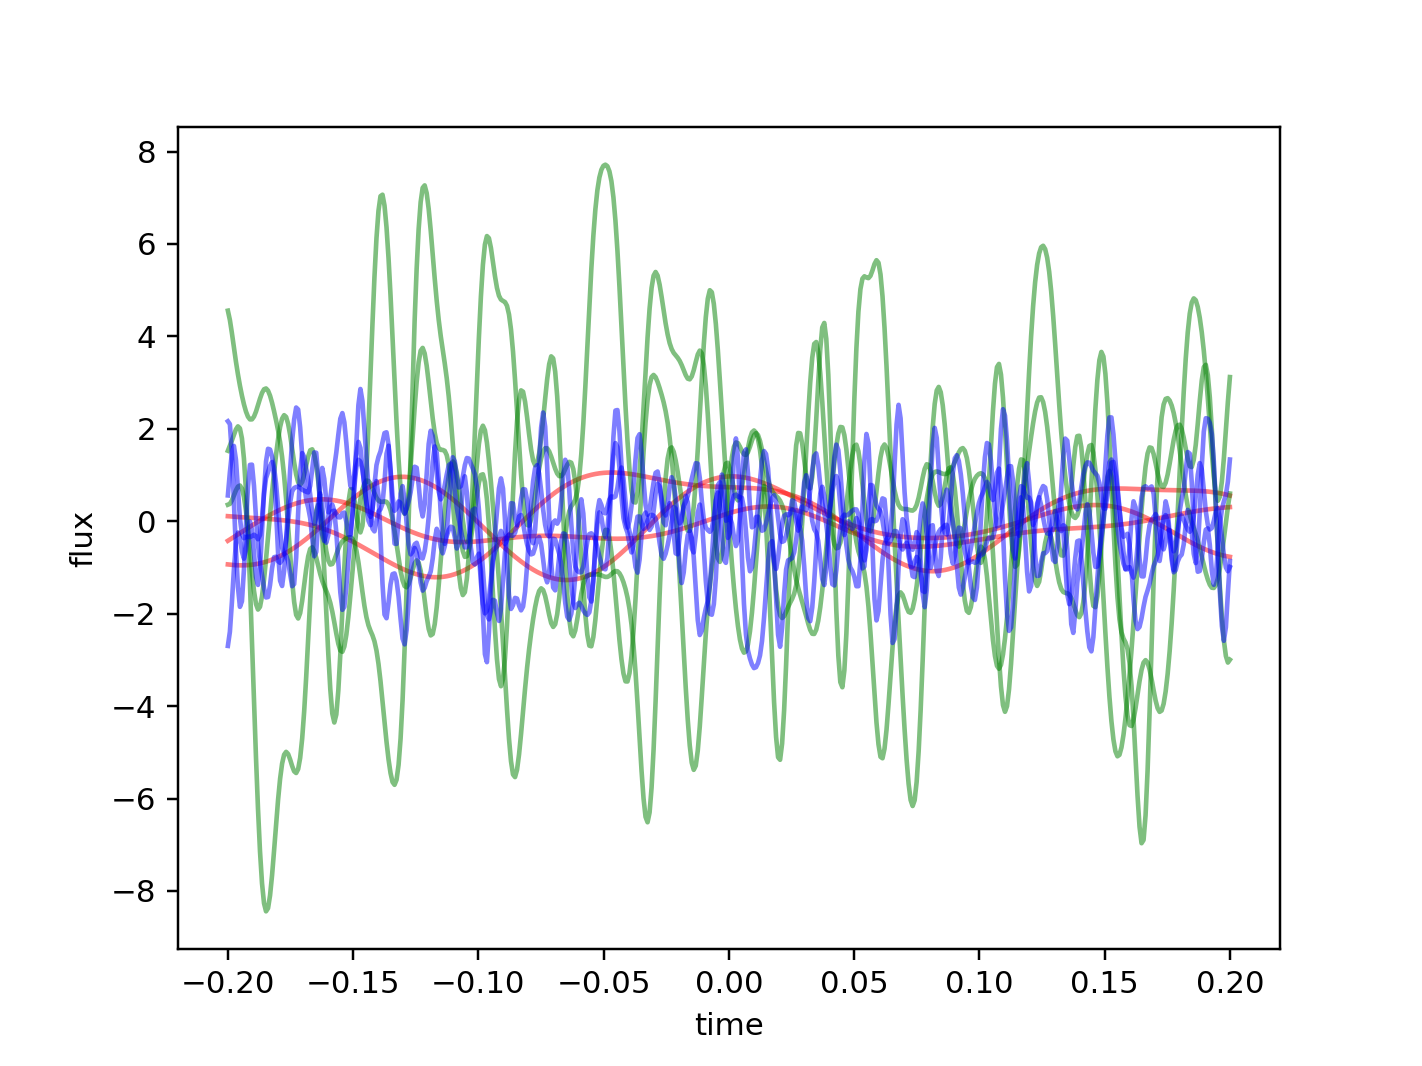

Text(0.5, 0, 'time')

In [13]:
#now lets define the mean and covariance
m = np.zeros(time_pred.size)
K = kf(time_pred,time_pred,[1,0.04,0.0],wn=True)

#take some random draws and plot
draws = np.random.multivariate_normal(m,K,3)
f,a = plt.subplots(1)
a.plot(time_pred,draws.T,'r-',alpha=0.5)
a.set_ylabel('flux')
a.set_xlabel('time')

In [14]:
#let's decrease the length scale and increase the height scale
K = kf(time_pred,time_pred,[3,0.005,0.01],wn=False)
draws = np.random.multivariate_normal(m,K,3)
a.plot(time_pred,draws.T,'g-',alpha=0.5)

In [15]:
K = kf(time_pred,time_pred,[1,0.002,0.01],wn=False)
draws = np.random.multivariate_normal(m,K,3)
a.plot(time_pred,draws.T,'b-',alpha=0.5)

So we can now draw random functions from a prior distriution. This this isn't very useful yet - we want to use GPs to fit datasets and make predictions!

The final thing we need to consider are how to find the mean and covariance of a GP *after* we have made some observations. Luckily, it's really easy to compute conditional likelhoods from Gaussian distributions! We simply need the mean and covariance of the observed data points, the mean and covariance of the points where we want to make a prediction, and finally, the covariance between the observated points and predicted points. 

As stated above, a normal distribution is fully defined by its mean and covariance:

$
\begin{align}
\mathcal{N}(\mu,\Sigma)
\end{align}
$

If we want to find the *conditional* distribution of a set of inputs based on some observed data, we simply have to partition the mean and covariance matrix, and consider the covariance of the observed data ($K$), the covariance of the inputs with themselves ($K_{\star\star}$), and the covariance of the inputs with the observed data ($K_\star$) :

$
\begin{align}
\mathcal{N}\left(\begin{bmatrix}
\mu \\
\mu_\mathrm{\star}
\end{bmatrix}
,
\begin{bmatrix}
\Sigma & K_{\star}^T \\
K_{\star} & K_{\star\star} \\
\end{bmatrix}
\right)
\end{align}
$

The conditional mean and covariance of the function at the location of the inputs is then given by $\mathcal{N}(\mu_\star,\Sigma_{\star})$, with:

$
\begin{align}
\mu_\star &= mf(x_\star) + K_\star^T \Sigma^{-1} r \\
\Sigma_{\star} &= K_{\star\star} - K_\star^T \Sigma^{-1} K_\star
\end{align}
$




In [16]:
def GPpredict(p,mf,kf,x,y,x_pred,wn=False):
  """
  Simple function to find the conditional distribution for a GP
  p - hyperparameters of the kernel function
  mf - mean function
  kf - kernel function
  x - position of observed points
  y - observed points
  x_pred - position of points to make a prediction
  
  """
  
  #first get residuals
  mean = mf(p[:-3],x)
  mean_pred = mf(p[:-3],x_pred)
  r = y - mean

  #now let's get the conditional distibution - first get covariance for training + predictive sets
  K = kf(x,x,p[-3:],wn=True) # K for observations
  Ks = kf(x_pred,x,p[-3:],wn=False) #K for obs + predictions
  Kss = kf(x_pred,x_pred,p[-3:],wn=wn) # K for points where we want to make a prediction

  choF = cho_factor(K,check_finite=False)
  m_cond = np.dot(Ks,cho_solve(choF,r,check_finite=False))
  K_cond = Kss - np.dot(Ks,cho_solve(choF,Ks.T,check_finite=False))

  return m_cond+mean_pred,K_cond

<IPython.core.display.Javascript object>


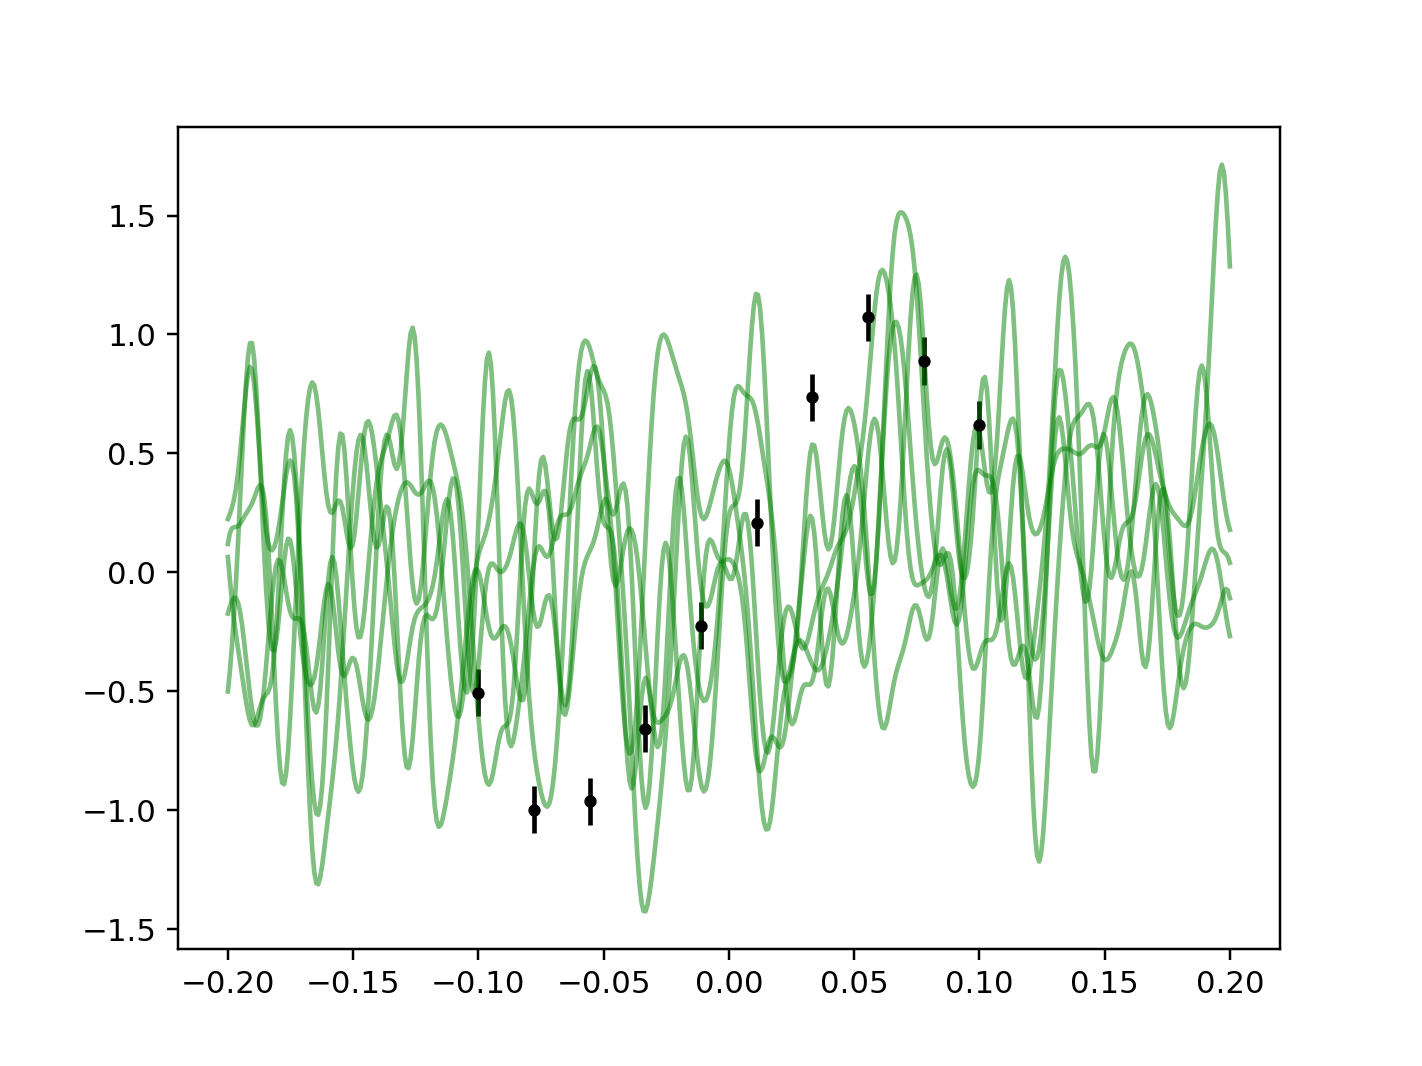

In [17]:
#let's make some observations of 10 points along time
time_obs = np.linspace(-0.1,0.1,10)
wn_test = 0.1
flux_obs = np.sin(time_obs*2*np.pi*4) + np.random.normal(0,wn_test,time_obs.size)

#we'll also define a trivial mean function
def mf(p,*args): return p[0]

#plot the observations
f,a = plt.subplots(1)
a.errorbar(time_obs,flux_obs,yerr=wn_test,fmt='k.')

#and also some samples from the prior distribution
Kprior = kf(time_pred,time_pred,[0.5,0.005,wn_test],wn=False)
draws = np.random.multivariate_normal(m,Kprior,5)
a.plot(time_pred,draws.T,'g-',alpha=0.5)

<IPython.core.display.Javascript object>


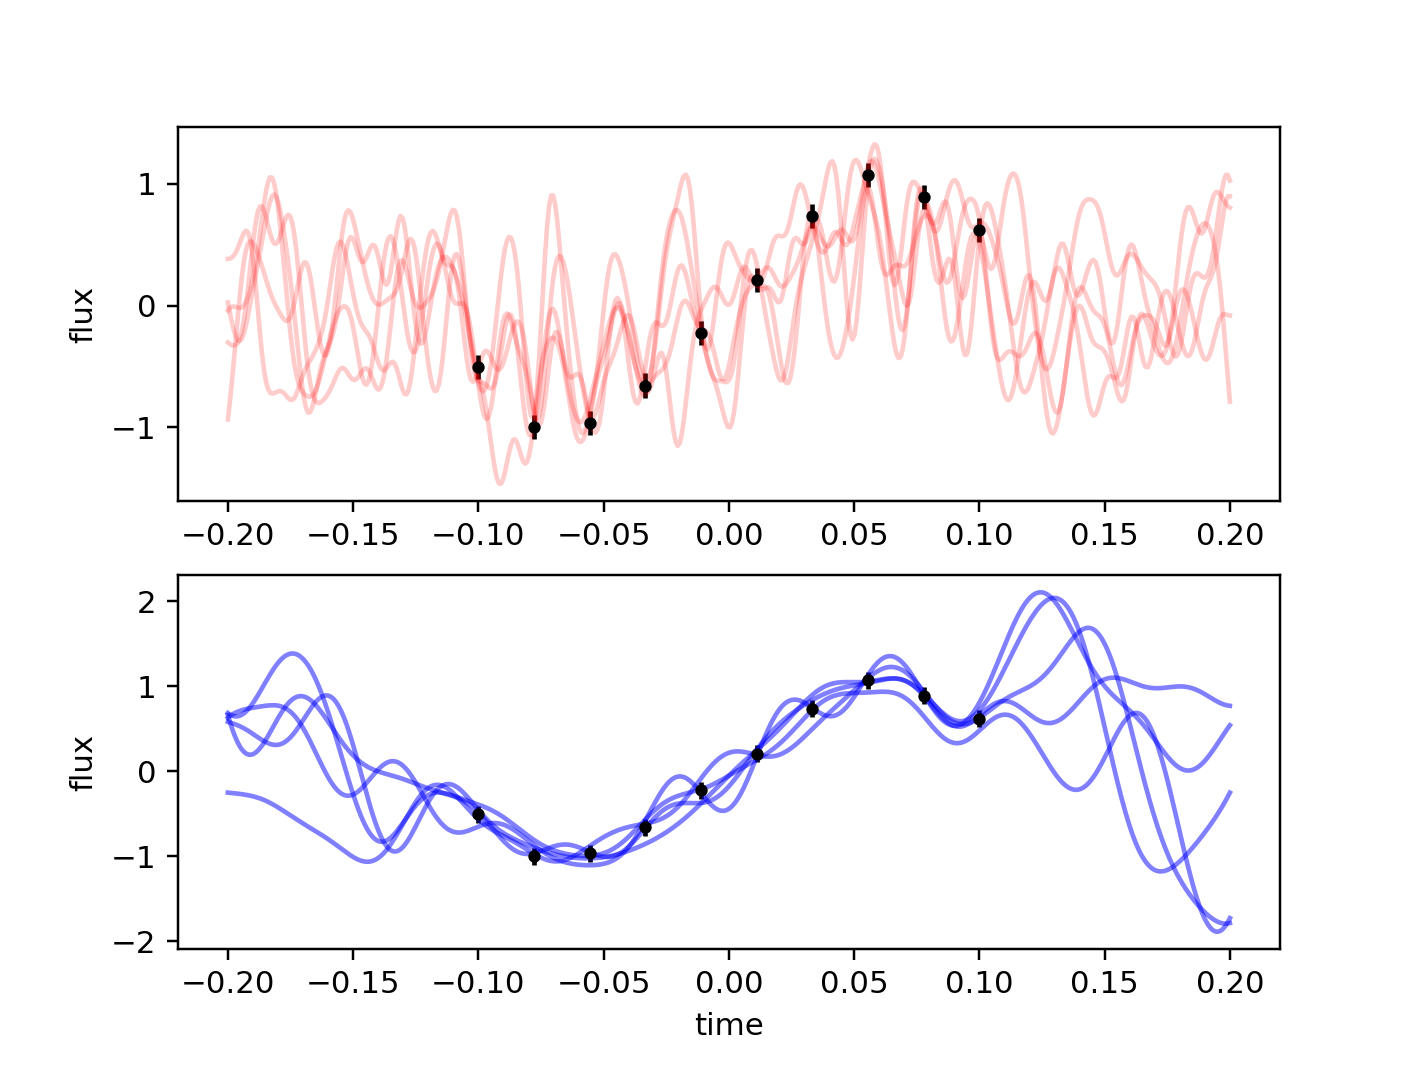

(500,) (500,) (500, 500)
(500,) (500, 500)


Text(0.5, 0, 'time')

In [18]:
f,a = plt.subplots(2)
a[0].errorbar(time_obs,flux_obs,yerr=0.1,fmt='k.')
a[1].errorbar(time_obs,flux_obs,yerr=0.1,fmt='k.')

m_cond,K_cond = GPpredict([0,0.5,0.005,wn_test],mf,kf,time_obs,flux_obs,time_pred)
print(time_pred.shape,m_cond.shape,K_cond.shape)
#finally we can take some draws from the posterior distribution
draws = np.random.multivariate_normal(m_cond,K_cond,5)
a[0].plot(time_pred,draws.T,'r-',alpha=0.2)

# let's see what happens if we change the length scale
m_cond,K_cond = GPpredict([0,1,0.02,wn_test],mf,kf,time_obs,flux_obs,time_pred)
print(m_cond.shape,K_cond.shape)

#finally we can take some draws from the posterior distribution
draws = np.random.multivariate_normal(m_cond,K_cond,5)
a[1].plot(time_pred,draws.T,'b-',alpha=0.5)

a[0].set_ylabel('flux')
a[1].set_ylabel('flux')
a[1].set_xlabel('time')

***

## Learning the hyperparameters

The parameters of the kernel function are ofter referred to as 'hyperparameters', but they can be treated in exactly the same way as 'normal' parameters. 

*In GP terminology the mean function parameters may also be considered 'hyperparameters'.*



Optimization terminated successfully.
         Current function value: -10.293455
         Iterations: 252
         Function evaluations: 431


<IPython.core.display.Javascript object>


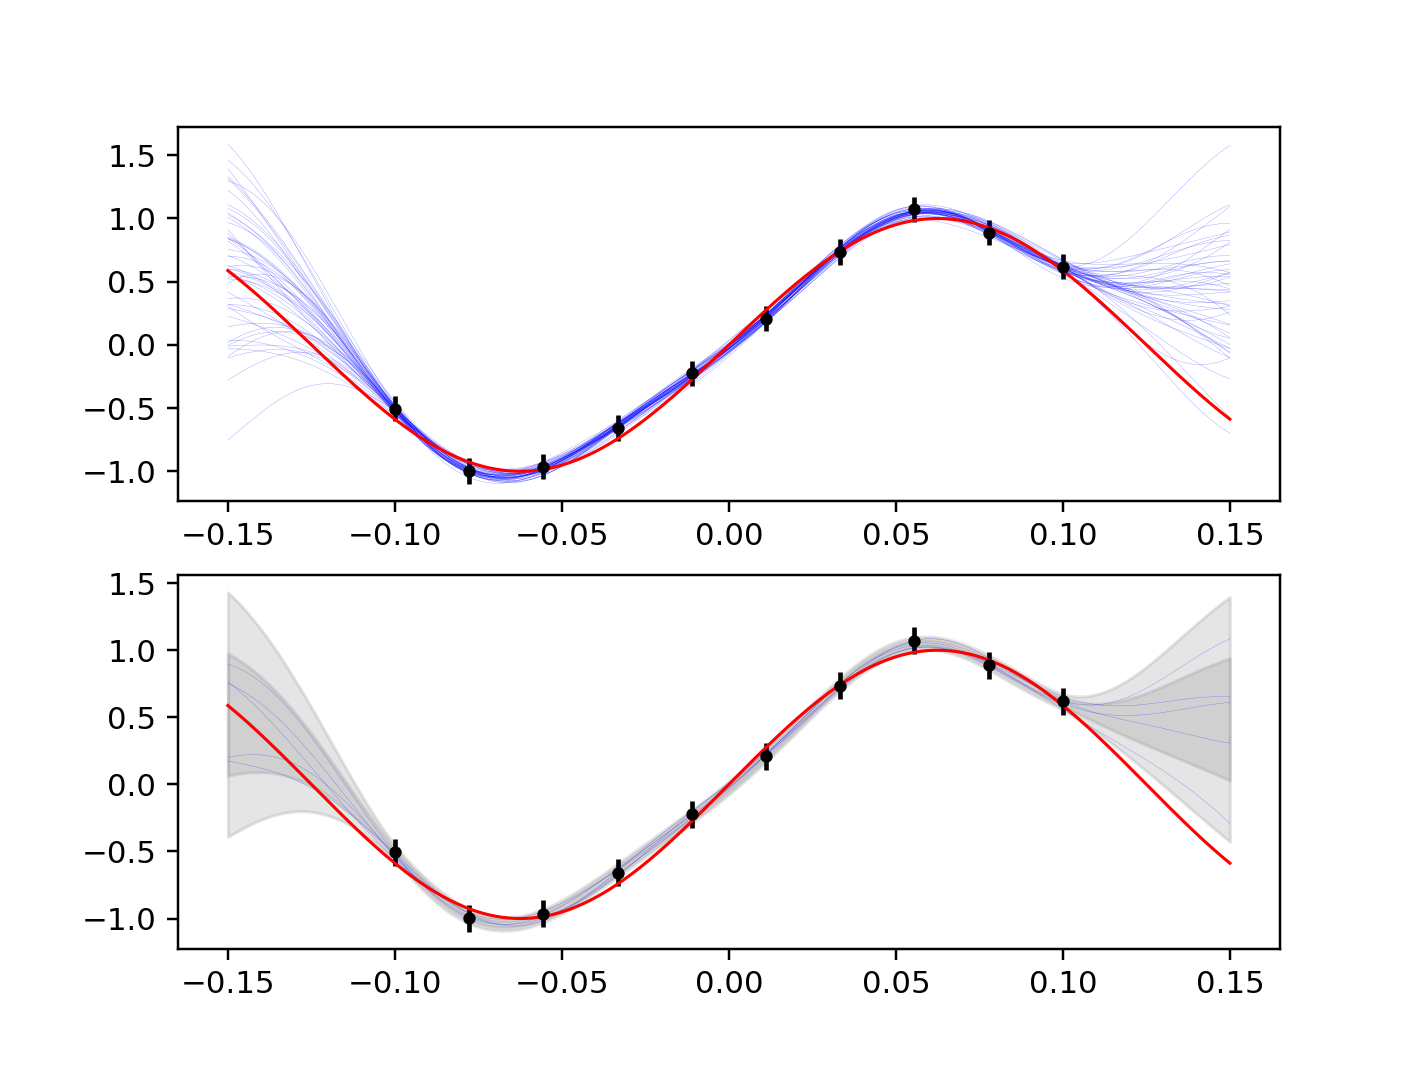

In [19]:

def logL_GP(p,mf,kf,x,y):
  #get the residuals and covariance matrix
  r = y - mf(p[:-3],x)
  K = kf(x,x,p[-3:],wn=True)
  #then compute the log Likilihood for a multivariate Gaussian
  return logL_multivariate_normal(r,K)

#finally we can add some prior bounds on the hyperparameters
logP_GP = apply_uniform_prior(logL_GP,[None,(0.,np.inf),(0,time_pred.ptp()),(0.0001,np.inf)])

#and try and find the hyperparamters by optimisation
p,e = np.array([0,1,0.1,0.1]),np.array([0.1,1,0.07,0.05])
p_fit = fopt(logP_GP,p,var=e>0,args=(mf,kf,time_obs,flux_obs),min=False)

#let's get the mean and covariance again
m_post,K_post = GPpredict(p_fit,mf,kf,time_obs,flux_obs,time)
stdev = np.sqrt(np.diag(K_post))

#take some draws from the conditional distribution
draws = np.random.multivariate_normal(m_post,K_post,50)

#plot the observations
f,a = plt.subplots(2)
a[0].errorbar(time_obs,flux_obs,yerr=0.1,fmt='k.')
a[1].errorbar(time_obs,flux_obs,yerr=0.1,fmt='k.')

a[0].plot(time,draws.T,'b-',alpha=0.5,lw=0.1)



#we can also plot the variance of the predicted function
#a[1].fill(time,draws.T,'b-',alpha=0.5)

#a[1].fill_between(x, y1, y2, where=y1>=y2, facecolor=c2,lw=lw2,alpha=alpha)
a[1].fill_between(time, m_post-2*stdev, m_post+2*stdev,color='0.5',alpha=0.2)
a[1].fill_between(time, m_post-1*stdev, m_post+1*stdev,color='0.5',alpha=0.2)
draws = np.random.multivariate_normal(m_post,K_post,5)
a[1].plot(time,draws.T,'b-',alpha=0.5,lw=0.1)

#overplot the function that the data were taken from
a[0].plot(time,np.sin(time*2*np.pi*4),'r-',alpha=1,lw=1)
a[1].plot(time,np.sin(time*2*np.pi*4),'r-',alpha=1,lw=1)


***

## Putting it all together - applying to transits

Now we have a working GP, we can apply these modelling functions to our transit model.

First we'll simulate a new transit dataset with a little systematics

<IPython.core.display.Javascript object>


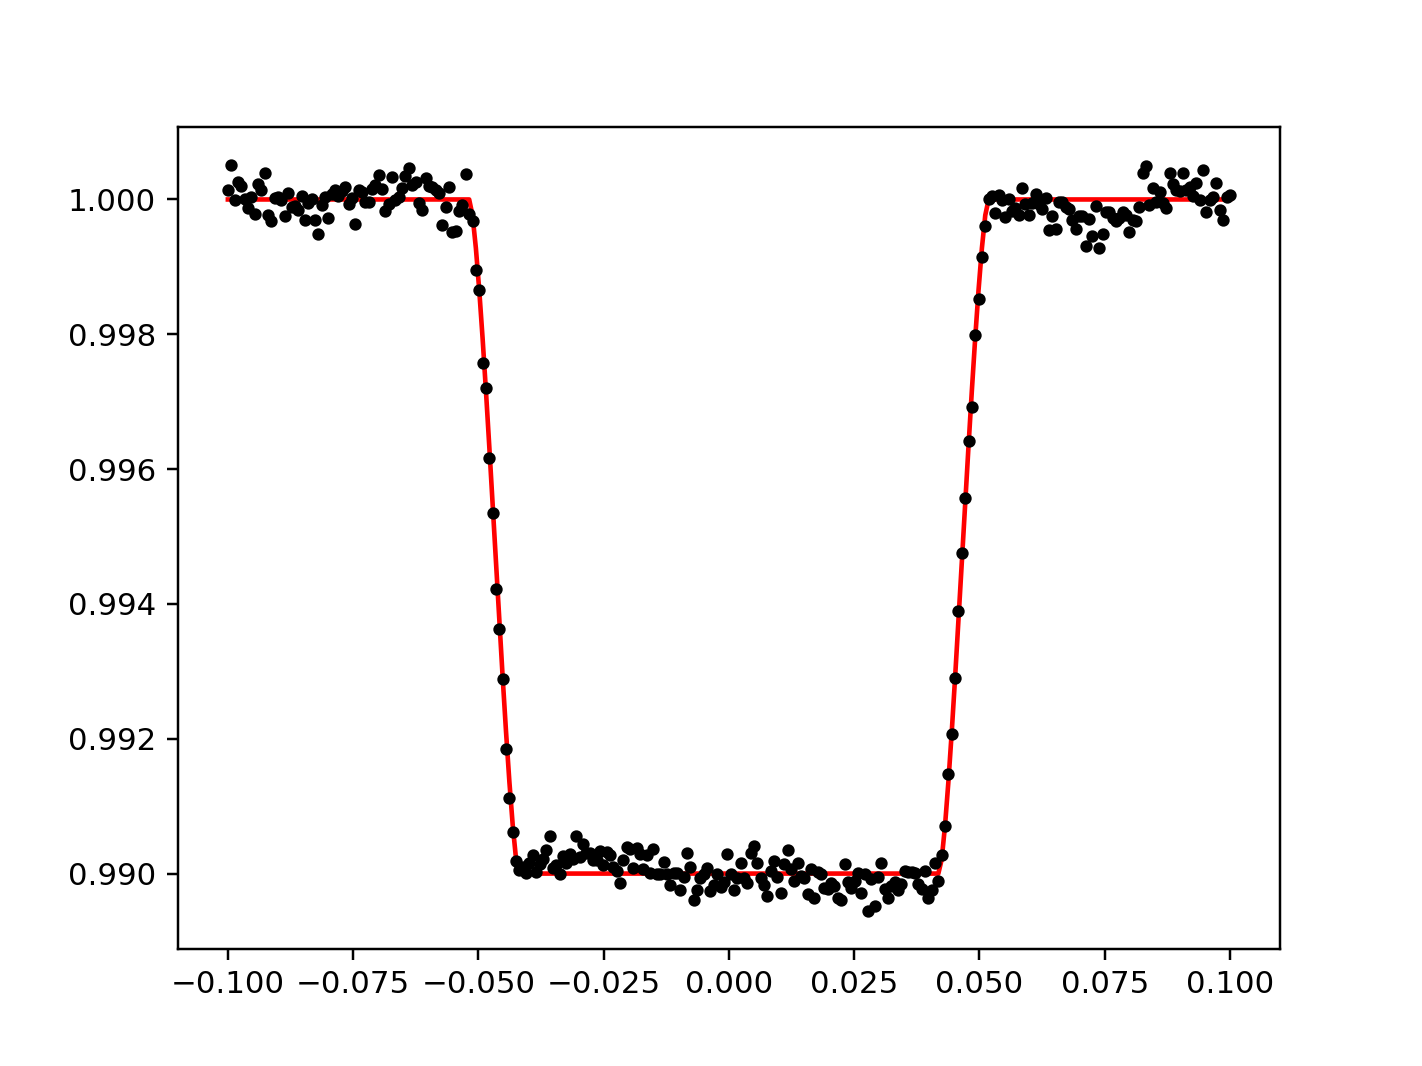

In [20]:
time = np.linspace(-0.1,0.1,300)
par = np.array([0,3,10,0.1,0.2,1.,0])
hp = np.array([0.0003,0.01,wn])
wn = 0.0002 # white noise
draw = np.random.multivariate_normal(np.zeros(time.size),kf(time,time,hp))
flux = transit(par,time) + draw #+ np.random.normal(0,wn,time.size)

plt.figure()
plt.plot(time, transit(par,time),'r-')
plt.plot(time,flux,'k.')


Now we can optimise as before!

In [21]:
#create starting guess + uncertainties for transit + hyperparameters
p = np.array([0,3,10,0.08,0.2,1.001,0.001] + [0.0004,0.01,wn])
e = np.array([0,0.,0.,0.01,0.0,0.0001,0.0001] + [0.0001,0.001,0.001])

#let's add some prior bounds to get our posterior function
logP_GP = apply_uniform_prior(logL_GP,transit_bounds+[(0.,np.inf),(0,3*time.ptp()),(0.0001,np.inf)])

#optimise the function
p_fit = fopt(logP_GP,p,var=e>0,args=(transit,kf,time,flux),min=False)

#run an MCMC
n_chains,burnin,chain = 64,100,100
d = miniMCMC(logP_GP,p_fit,e/100,burnin,chain,N=n_chains,args=(transit,kf,time,flux))
p_fit_MCMC,e_fit_MCMC = d['p'],d['e'] #get mean and uncertainties

Optimization terminated successfully.
         Current function value: -2411.185044
         Iterations: 248
         Function evaluations: 399


running mcmc chain:   0%|          | 0/200 [00:00<?, ?it/s]

Total time: 0m 15.02s
Final acceptance = 25.21875%


<IPython.core.display.Javascript object>


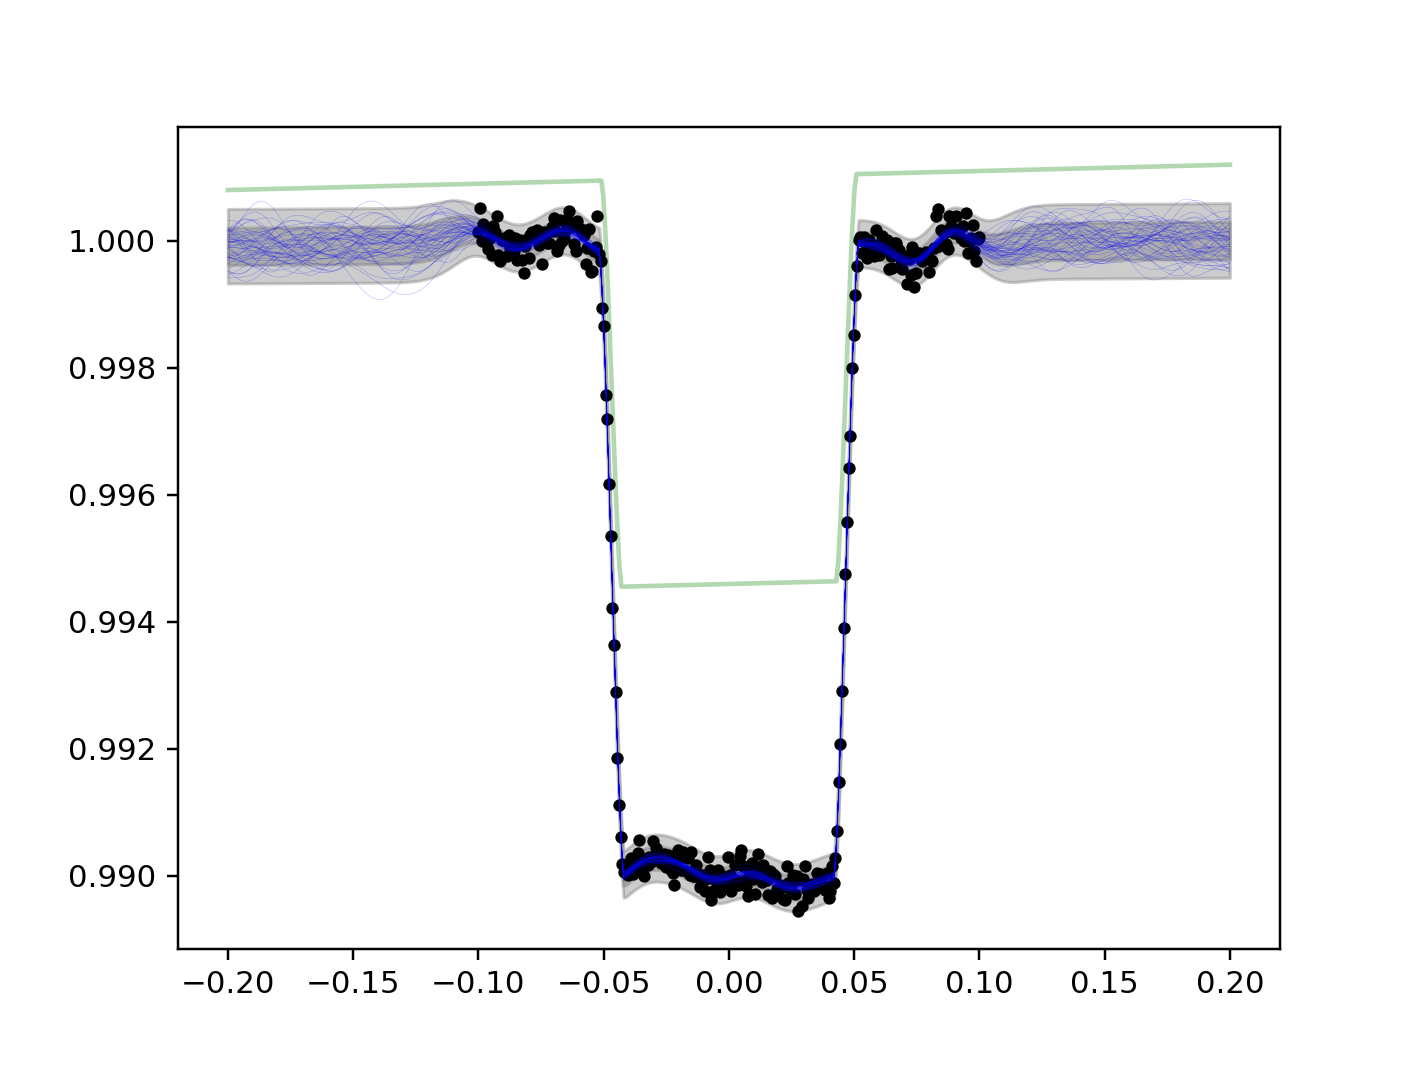

<IPython.core.display.Javascript object>


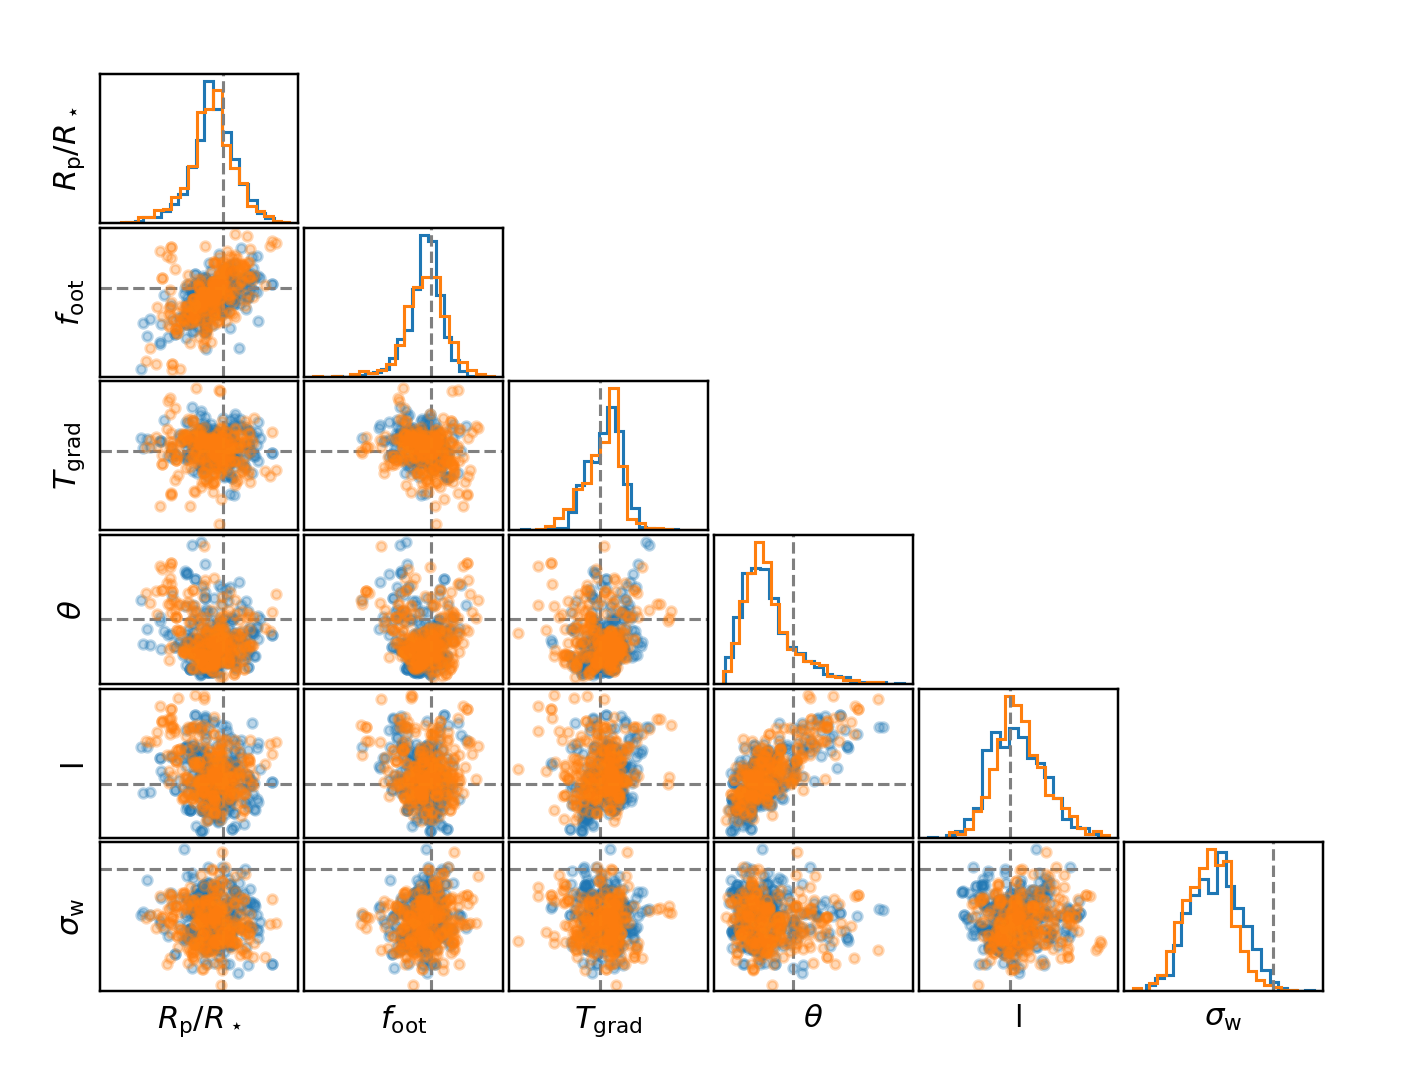

p[0] = 0.00000 +- 0.00000
p[1] = 3.00000 +- 0.00000
p[2] = 10.00000 +- 0.00000
p[3] = 0.09964 +- 0.00073
p[4] = 0.20000 +- 0.00000
p[5] = 0.99996 +- 0.00012
p[6] = 0.00023 +- 0.00120
p[7] = 0.00023 +- 0.00008
p[8] = 0.01066 +- 0.00205
p[9] = 0.00018 +- 0.00001


In [22]:
#plot the initial guess of the transit
f,a = plt.subplots()
a.plot(time_pred,transit(p[:-3],time_pred),'g-',alpha=0.3)
a.plot(time,flux,'k.')

#get the GP fit and some draws
#def GPpredict(p,mf,kf,x,y,x_pred,wn=False):
m_post,K_post = GPpredict(p_fit_MCMC,transit,kf,time,flux,time_pred)
draws = np.random.multivariate_normal(m_post,K_post,50)
#redo with white noise
m_post,K_post = GPpredict(p_fit_MCMC,transit,kf,time,flux,time_pred,wn=True)
stdev = np.sqrt(np.diag(K_post))

#plot the draws
a.plot(time_pred,draws.T,'b-',alpha=0.5,lw=0.1)

#plot the 1+2 sigma distributions
a.fill_between(time_pred, m_post-2*stdev, m_post+2*stdev,color='0.5',alpha=0.4)
a.fill_between(time_pred, m_post-1*stdev, m_post+1*stdev,color='0.5',alpha=0.4)

#show plot of chains - need to update this function
miniSamplePlot(d['chains'],2,labels=transit_labels+[r'$\theta$',r'l',r'$\sigma_\mathrm{w}$'],x=np.hstack([par,hp]))

#print results of MCMC
for i in range(len(p)):
  print("p[{}] = {:.5f} +- {:.5f}".format(i,p_fit_MCMC[i],e_fit_MCMC[i]))

***

# Taking it further

This tutorial covers a very simple, yet practical GP using only numpy and scipy! There are a number of ways to speed things up, and also make modelling with GPs much easier.

There are a number of improvements we might make, e.g.:
- use a realistic transit model with limb darkening
- use log parameters for the height scale and length scale, which are strictly positive parameters
- in this case we have regularly sampled data, and so could exploit the Toeplitz structure to speed up inference
- use a more sophisticated 'tunable' MCMC

While I would encourage you to write your own codes to get a better understanding of systematics modelling, there are also many codes out there that can help, e.g.:
- Transit modelling: BATMAN
- GPs: george, celerite, GeePea
- MCMC: emcee
(apologies if I've missed any)

The codes I use are available on github:
- Transits: https://github.com/nealegibson/MyFuncs
- GPs: https://github.com/nealegibson/GeePea
- Inference (MCMC/optimisers): https://github.com/nealegibson/inferno

Below is an example of how I might use them to fit a series of light curves. These can be installed as follows (I make no guarantees they will work on your machine!):

GeePea:
```
git clone https://github.com/nealegibson/GeePea
cd GeePea
python setup.py install #to default location
# python setup.py install --prefix=$HOME #to home
```
inferno:
```
git clone https://github.com/nealegibson/inferno
cd inferno
python setup.py install #to default location
# python setup.py install --prefix=$HOME #to home
```
PlanetFuncs: You'll first need to install the GSL C library (GSL) if you don't have it. Luckily there is a verion on conda to make this nice and simple (installing from source is straightforward if you prefer).

```
conda install gsl
git clone https://github.com/nealegibson/PlanetFuncs
cd PlanetFuncs
python setup.py install #to default location
# python setup.py install --prefix=$HOME #to home
```
